# BT4222 Project -Toxic Comments Classifier (EDA Semantic, Sentiment, Statistical)

In this notebook, we will perform EDA on the data using techniques taught in class. We will primarily be doing semantic analysis (Topic Modelling), Syntactic Analysis (NER-Separate Notebook), Sentiment Analysis and Statistical Analysis. For full elaboration on the results, please refer to the report.

In [2]:
import pandas as pd
import numpy as np
import os
import nltk
import gc
import warnings
import re
import sys
import csv
import pickle
from time import ctime, time
from collections import defaultdict
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import seaborn as sns
%matplotlib inline

import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import LsiModel,LdaModel,TfidfModel, HdpModel
from gensim.models.hdpmodel import HdpModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models.coherencemodel import CoherenceModel
import nltk
from nltk.tokenize import RegexpTokenizer,sent_tokenize,word_tokenize,TweetTokenizer 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from textblob import TextBlob 
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import warnings
warnings.filterwarnings("ignore")
#project_dir = r"C:\Users\User\Desktop\JeremyWork\BT4222\"

C:\Users\User\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
data = pd.read_csv("cleaned_train.csv")

In [4]:
data_v2 = pd.read_csv("sanitize1_train.csv")

In [5]:
data.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  explanation edits made username hardcore metal...      0   
1  000103f0d9cfb60f  aww matches background colour seemingly stuck ...      0   
2  000113f07ec002fd  hey man really trying edit war guy constantly ...      0   
3  0001b41b1c6bb37e  make real suggestions improvement wondered sec...      0   
4  0001d958c54c6e35                      sir hero chance remember page      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [6]:
#check for missing values

data['comment_text'].isnull().sum()

50

In [7]:
# Fill na with empty string

data['comment_text'].fillna("", inplace=True)

## Statistical Analysis: Toxic Comment Distribution

In [8]:
data['class_count'] = data.iloc[:,2:].sum(axis = 1, skipna = True)

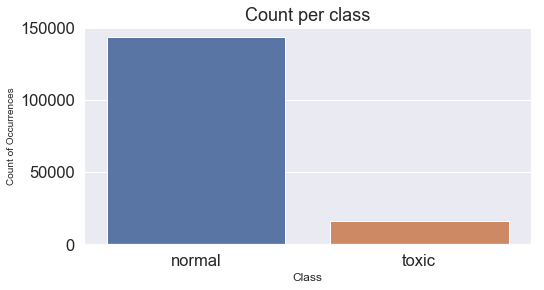

In [79]:
multi_class=data.iloc[:,2:].sum(axis = 1, skipna = True).value_counts()
normal = multi_class[0]
anomalous = sum(multi_class[1:])

plt.figure(figsize=(8,4))
plt.title("Count per class")
plt.ylabel('Count of Occurrences', fontsize=10)
plt.xlabel('Class', fontsize=12)
ax = sns.barplot(["normal","toxic"],np.array([normal,anomalous]))

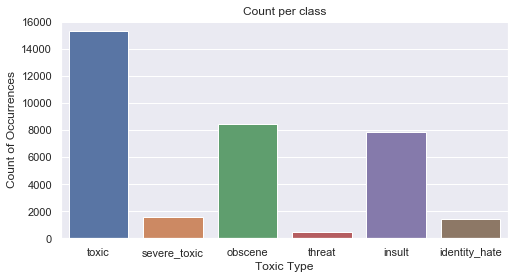

In [97]:
x=data.iloc[:,2:-1].sum()
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values)
plt.title("Count per class", fontsize=12)
plt.ylabel('Count of Occurrences', fontsize=12)
plt.xlabel('Toxic Type', fontsize=12)
sns.set(font_scale=1)

## Multi Class Comments

Text(0.5, 0, '# of tags ')

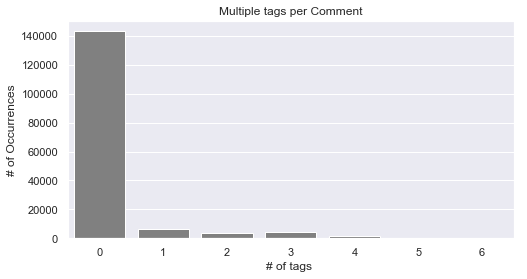

In [101]:
multi_class=data.iloc[:,2:-1].sum(axis = 1, skipna = True).value_counts()

plt.figure(figsize=(8,4))
ax = sns.barplot(multi_class.index, multi_class.values,color='grey')
plt.title("Multiple tags per Comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

## Correlation between Categories

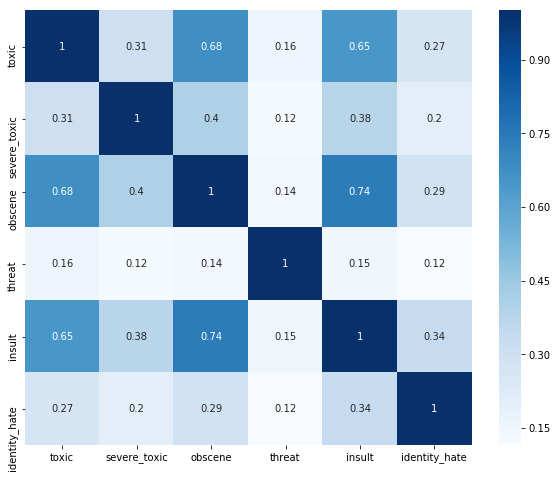

In [240]:
main_data=data.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=main_data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values, annot=True,cmap='Blues')

## Wordcloud Normal Text

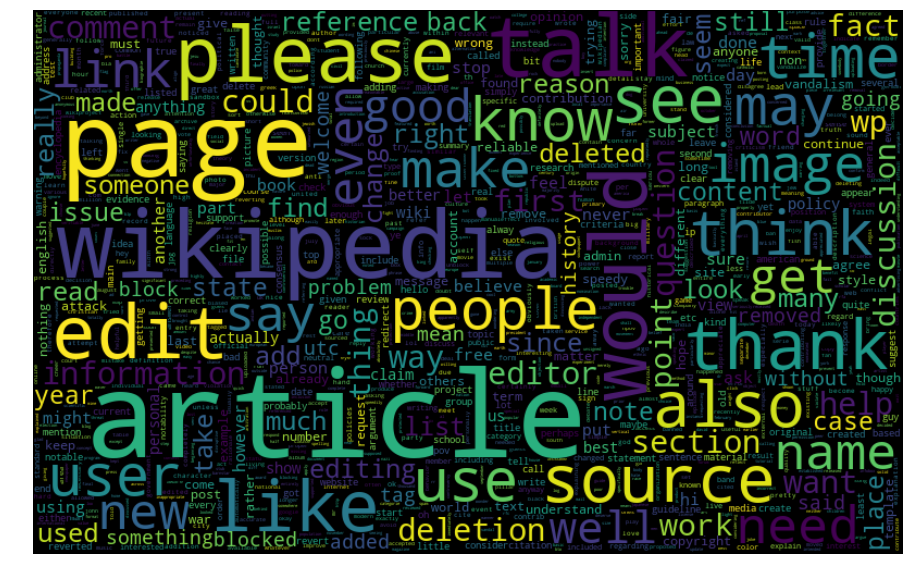

In [28]:
normal_text = data[data['class_count'] == 0]

new_stopwords = stop_words + ["one","two","three","four","five","six","seven","eight","nine"]
# list_sent = [" ".join(text) for text in text_data]
# all_words = ' '.join([text for text in list_sent])
all_words = ' '.join([text for text in normal_text["comment_text"]])
wordcloud = WordCloud(max_words=2000,width=800, height=500, random_state=21, max_font_size=110,stopwords=new_stopwords,collocations=False).generate(all_words)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [29]:
data_dict = {}

data_dict['normal'] = normal_text

for i in data.columns[2:-1]:
    data_dict[i] = data[data[i] == 1]
# df_toxic = data[data.toxic == 1]
# df_severe_toxic = data[data.severe_toxic == 1]
# df_obscene = data[data.obscene == 1]
# df_threat = data[data.threat == 1]
# df_insult = data[data.insult == 1]
# df_identity_hate = data[data.identity_hate == 1]

In [30]:
data_dict_v2 = {}

for i in data.columns[2:-1]:
    data_dict_v2[i] = data_v2[data_v2[i] == 1]

In [31]:
[i for i in data_dict]

['normal',
 'toxic',
 'severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate']

## Sentiment Analysis

In [51]:
sid = SentimentIntensityAnalyzer()

sentiment_dict = {}

for i in data_dict:
    class_sentiment = []
    curr_text_data = data_dict[i]['comment_text'].tolist()
    for j in curr_text_data:
        try:
            class_sentiment.append(sid.polarity_scores(j))
        except:
            print(i)
            class_sentiment.append(0)
    sentiment_dict[i] = class_sentiment

In [52]:
import pickle

project_dir = r"C:\Users\User\Desktop\BT4222\New folder"

#pickle.dump(sentiment_dict,open(os.path.join(project_dir,'sentiment_dict.p'),'wb'))
sentiment_dict = pickle.load(open(os.path.join(project_dir,'sentiment_dict.p'),"rb"))

In [53]:
for i in sentiment_dict:
    curr_sentiments = pd.DataFrame(sentiment_dict[i])
    curr_class = curr_sentiments.assign(Text = data_dict[i]['comment_text'].tolist()).iloc[:,[-1, 0,1,2,3]]
    sentiment_dict[i] = curr_class

In [55]:
sentiment_dict['toxic']

Text    neg    neu    pos  \
0                            cocksucker piss around work  0.773  0.227  0.000   
1      hey talk exclusive group wp talibans good dest...  0.280  0.463  0.257   
2                bye look come think comming back tosser  0.000  1.000  0.000   
3      gay antisemmitian archangel white tiger meow g...  0.189  0.739  0.072   
4                             fuck filthy mother ass dry  0.700  0.300  0.000   
...                                                  ...    ...    ...    ...   
15289  previous conversation fucking shit eating libe...  0.352  0.648  0.000   
15290                            mischievious pubic hair  0.000  1.000  0.000   
15291  absurd edits absurd edits great white shark to...  0.404  0.413  0.183   
15292  hey listen ever delete edits ever annoyed wwe ...  0.478  0.434  0.088   
15293  going keep posting stuff deleted fucking site ...  0.421  0.412  0.167   

       compound  
0       -0.7783  
1       -0.4588  
2        0.0000  
3       -0.8451  
4       -0.7906  
...         ...  
15289   -0.9972  
15290    0.0000  
15291   -0.8949  
15292   -0.9829  
15293   -0.8817  

[15294 rows x 5 columns]

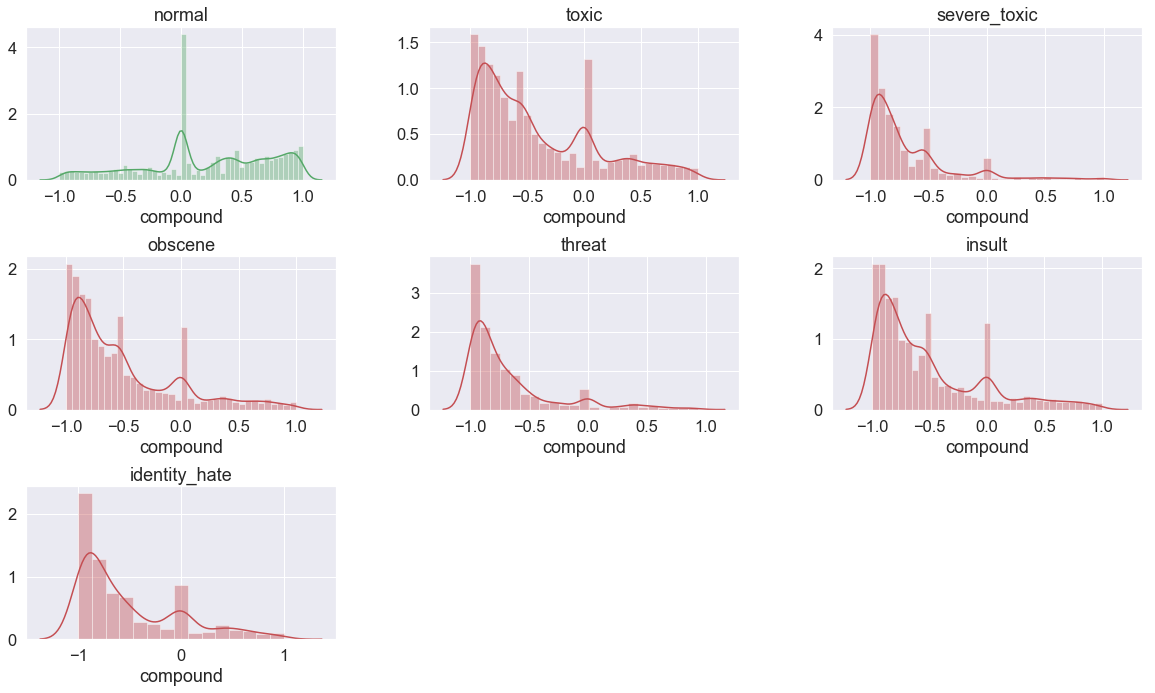

In [58]:
fig = plt.figure(constrained_layout=False, figsize=(20,100))
spec = fig.add_gridspec(24, 3, wspace=0.3, hspace=0.5)
sns.set(font_scale=1.5)

for i,c in enumerate(sentiment_dict):
    axes = fig.add_subplot(spec[i])
    if c == "normal":
        sns.distplot(sentiment_dict[c]['compound'],color="g")
    else:
        sns.distplot(sentiment_dict[c]['compound'],color="r")
    fig.add_subplot(axes)
    axes.title.set_text(c)

fig.show()


# plt.figure(figsize=(6, 6))
# sns.set(font_scale=1)
# sns.distplot(sentiment_dict['toxic']['compound'])

## Semantic Analysis - Topic Modelling

We will look at what are the common topics talk about in each type of toxic comments

### Preprocessing

`prepare_corpus_part1` - Lowercase, tokenization, removal of stop words and generates bigrams and trigrams on text

`prepare_corpus_part2` - POS tag each token and keep only 'NOUN','VERB','ADJECTIVE', this is decided after trying various combinations of tags.

`prepare_corpus_part3` - Generates the dictionary and corpus needed for the modelling. Preprocessing is also done on the dictionary such as removing extremes (Too little occurance or too many).

In [21]:
stop_words = stopwords.words('english')
stop_words = stop_words + ["br","a","zero",'one','two','three','four','five','six','seven','eight','nine']  

def prepare_corpus_part1(df,bigram_min,trigram_min):
    df["comment_text"] = df["comment_text"].replace(np.nan, '', regex=True)
    text_data = df['comment_text'].tolist()
        
    text_data = [simple_preprocess(text,deacc=True) for text in text_data] 
    text_data = [[token for token in text if token not in stop_words] for text in text_data]
    
    bigram = Phrases(text_data,min_count=bigram_min) 
    trigram = Phrases(bigram[text_data], min_count=trigram_min)
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    
#    text_data = [trigram_mod[bigram_mod[text]] for text in text_data]
#    text_data = [bigram_mod[text] for text in text_data]
    
    return text_data

In [22]:
def prepare_corpus_part2(text_data,tags):
    
    result = []
    
    size = len(text_data)
    tracker = 0

    for tokenized_text in text_data:
        tracker += 1
        
        if tracker % 1000 == 0:
            print(f"Currently processing sentence {tracker}/{size}")
               
        tokens_tagged = nltk.pos_tag(tokenized_text)
        sub_result = [tokens for tokens in tokens_tagged if tokens[1] in tags]
        result.append(sub_result)
        
    return result

In [23]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    else:
        return ''

def prepare_corpus_part3(text_data,ext_below,ext_above):
    
    lemmatizer = WordNetLemmatizer()    
       
    text_data = [[lemmatizer.lemmatize(token[0],get_wordnet_pos(token[1])) for token in text if len(lemmatizer.lemmatize(token[0],get_wordnet_pos(token[1]))) >= 3] for text in text_data]
    
    dictionary = corpora.Dictionary(text_data)
    dictionary.filter_extremes(no_below=ext_below, no_above=ext_above)
    dictionary.compactify()
    
    corpus = [dictionary.doc2bow(text) for text in text_data]
    
    return dictionary, corpus, text_data

In [24]:
# compare different models and plot
def compute_coherence_values(dictionary, corpus, text_data, stop, start, step,iterations,passes):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        print ('Start modeling topic {} at {}'.format(num_topics,ctime()))
        model = LdaModel(corpus, num_topics=num_topics, alpha='auto', id2word = dictionary,random_state=4222,iterations=iterations,passes=passes)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=text_data, corpus=corpus, dictionary = dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print ('Model of {} topics has the coherence {}'.format(num_topics,coherencemodel.get_coherence()))
        
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
        
    return model_list, coherence_values

In [25]:
def format_unique_topics(topics):
    unique_topics = []
    
    for i in topics:
        if i[1] not in unique_topics:
            unique_topics.append(i[1])

    print("Number of unique topics:",len(unique_topics))

    formatted_topics = []

    for ind,j in enumerate(unique_topics):
        formatted_topics.append([ind,(j)])

    return formatted_topics

def convert_to_table(topics):
    import re
    sub_words = []
    for topic in topics:
        sub_words.append(re.findall(r'"(.*?)"', topic[1]))
       
    df = pd.DataFrame.from_records(sub_words)
    df = df.transpose()
    
    columns = ["Topic " + str(i) for i in range(1,len(topics)+1)]
    index = ["word " + str(i) for i in range(1,21)]

    df.columns = columns
    df.index = index
    
    return df

In [35]:
def popular_ngrams(df,n,top):
    df["cleaned_text"] = df['comment_text'].str.lower()
    df["cleaned_text"] = df["cleaned_text"].replace(np.nan, '', regex=True)
    df["cleaned_text"] = df["cleaned_text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

    ps = PorterStemmer()

    df["cleaned_text"] = df["cleaned_text"].apply(lambda x: ' '.join([ps.stem(w) for w in x.split()]))                                                         

    word_vectorizer = CountVectorizer(ngram_range=(n,n), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(df["cleaned_text"])
    frequencies = sum(sparse_matrix).toarray()[0]
    results = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
    results.sort_values(by=['frequency'],axis=0,ascending=False,inplace=True)
    results.head(70)
    plt.figure(figsize=(16, 16))
    sns.set(font_scale=2)
    ax = sns.barplot(x=results["frequency"][0:top],y=results.index.values[0:top])
    ax.set_title(f"Top {top} Most Frequent ngrams (removed stopword and performed stemming)")

### Clean/Normal Comments

In [73]:
tags = ['JJ','JJR','JJS','NN','NNS','NNP','NNPS','VB','VBD','VBG','VBN','VBP','VBZ']
#tags = ['NN','NNS','NNP','NNPS','VB','VBD','VBG','VBN','VBP','VBZ']

preprocess_text1 =  prepare_corpus_part1(data_dict['normal'],20,10)
preprocess_text2 =  prepare_corpus_part2(preprocess_text1,tags)
dictionary, corpus, text_data =  prepare_corpus_part3(preprocess_text2,5,0.6)

Currently processing sentence 1000/143346
Currently processing sentence 2000/143346
Currently processing sentence 3000/143346
Currently processing sentence 4000/143346
Currently processing sentence 5000/143346
Currently processing sentence 6000/143346
Currently processing sentence 7000/143346
Currently processing sentence 8000/143346
Currently processing sentence 9000/143346
Currently processing sentence 10000/143346
Currently processing sentence 11000/143346
Currently processing sentence 12000/143346
Currently processing sentence 13000/143346
Currently processing sentence 14000/143346
Currently processing sentence 15000/143346
Currently processing sentence 16000/143346
Currently processing sentence 17000/143346
Currently processing sentence 18000/143346
Currently processing sentence 19000/143346
Currently processing sentence 20000/143346
Currently processing sentence 21000/143346
Currently processing sentence 22000/143346
Currently processing sentence 23000/143346
Currently processing

Start modeling topic 5 at Tue Nov 19 02:07:32 2019
Model of 5 topics has the coherence 0.5485981799433227
Start modeling topic 10 at Tue Nov 19 02:17:17 2019
Model of 10 topics has the coherence 0.5331681263447943
Start modeling topic 15 at Tue Nov 19 02:31:35 2019
Model of 15 topics has the coherence 0.5297498719339059
Start modeling topic 20 at Tue Nov 19 02:45:26 2019
Model of 20 topics has the coherence 0.4948499465017668
Start modeling topic 25 at Tue Nov 19 02:59:50 2019
Model of 25 topics has the coherence 0.4533371641074821
Start modeling topic 30 at Tue Nov 19 03:14:38 2019
Model of 30 topics has the coherence 0.4292011877076121
Start modeling topic 35 at Tue Nov 19 03:30:52 2019
Model of 35 topics has the coherence 0.45708565104298665
Start modeling topic 40 at Tue Nov 19 03:48:20 2019
Model of 40 topics has the coherence 0.42580697362979114
Start modeling topic 45 at Tue Nov 19 04:01:27 2019
Model of 45 topics has the coherence 0.3983151862632063
Start modeling topic 50 at T

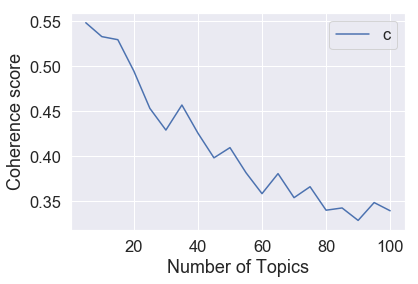

In [75]:
model_list_clean, coherence_values_clean = compute_coherence_values(dictionary, corpus, text_data, 101, 5, 5,100,10)
df_coherence_clean = pd.DataFrame(list(zip(list(range(2,11,1)),coherence_values_clean)),columns=('num_topics','coherence_value'))
best_index_clean = coherence_values_clean.index(max(coherence_values_clean))
best_model_clean = model_list_clean[best_index_clean]

In [78]:
dfclean = convert_to_table(format_unique_topics(model_list_clean[1].print_topics(num_topics=100, num_words=20)))
dfclean

Number of unique topics: 10


Topic 1     Topic 2    Topic 3     Topic 4     Topic 5    Topic 6  \
word 1         utc       style        lol     article       world  wikipedia   
word 2    category        game       year    deletion      school      image   
word 3    redirect       color        old      delete        high        use   
word 4         god         top       life         tag      system       page   
word 5        john       video    picture   wikipedia       group   question   
word 6   christian  background     record    template       force    welcome   
word 7        king       white        man        page      theory  copyright   
word 8    religion         get       film      speedy         law     please   
word 9     january        team      great         add       power       help   
word 10       july      series       date     notable      public       fair   
word 11      march       width  character      please       study       edit   
word 12     august      border      music     subject  university      thank   
word 13     muslim       movie        hey   guideline     control        ask   
word 14   february       align      photo   criterion       woman       file   
word 15      april         red        big        note     science       free   
word 16   december       award       love        talk   political       test   
word 17    october     episode        day      remove    military       talk   
word 18       town        best       song  notability      church       link   
word 19        jun       class    release       place         map     medium   
word 20      irish      season       play         web       human    article   

           Topic 7     Topic 8    Topic 9    Topic 10  
word 1        page     english    article  discussion  
word 2        talk    language        say      review  
word 3        edit     country     source        move  
word 4   wikipedia       state      think         new  
word 5      please    american        use       issue  
word 6         get      people        see   consensus  
word 7        user        city       make     project  
word 8        make         war       need         day  
word 9       block     british    section   community  
word 10     thanks      german      point     concern  
word 11    comment  government       find       month  
word 12       want      united      write        week  
word 13       know        live     people      result  
word 14       good       greek       name     dispute  
word 15     editor    national       fact     involve  
word 16     revert  population       give        vote  
word 17       look     century  reference     process  
word 18       take      region       link     support  
word 19        see         jew       seem         run  
word 20      edits      jewish        way      debate

### Toxic 

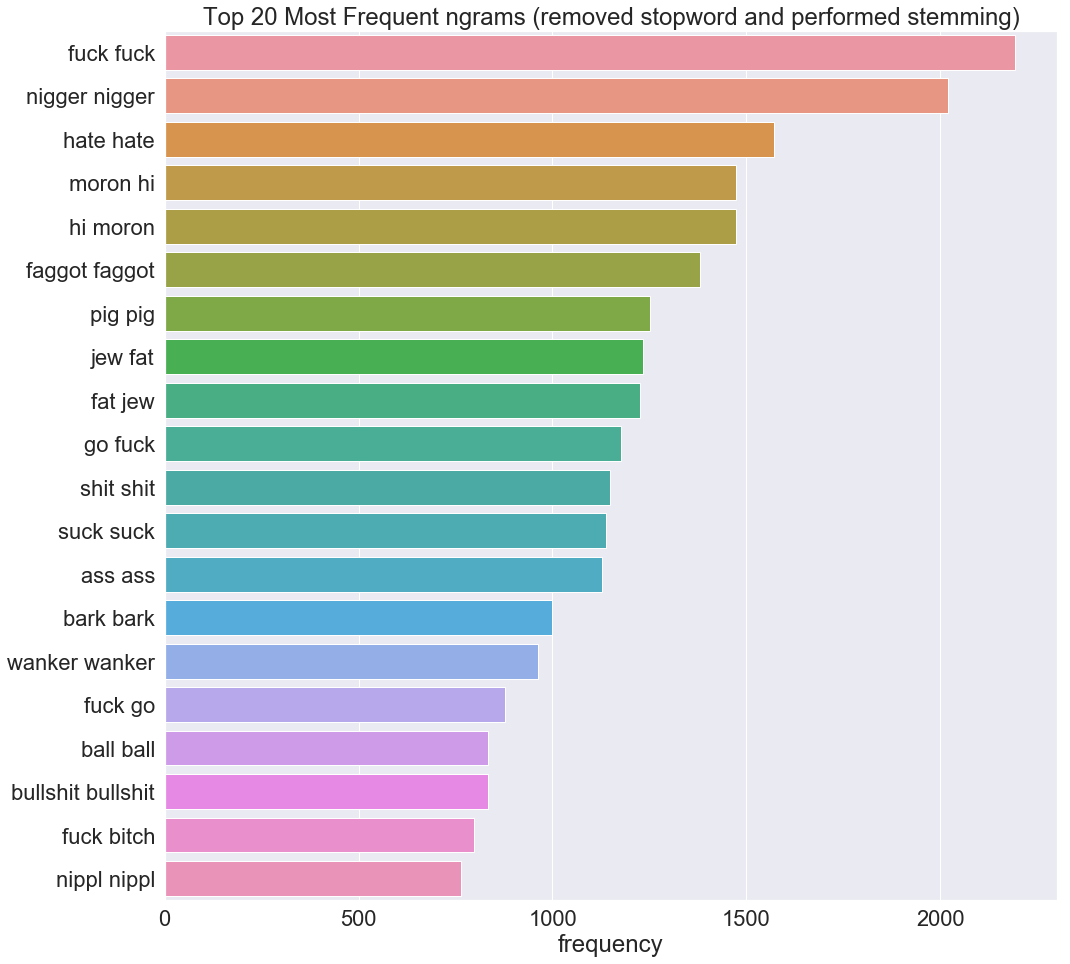

In [36]:
popular_ngrams(data_dict['toxic'],2,20)

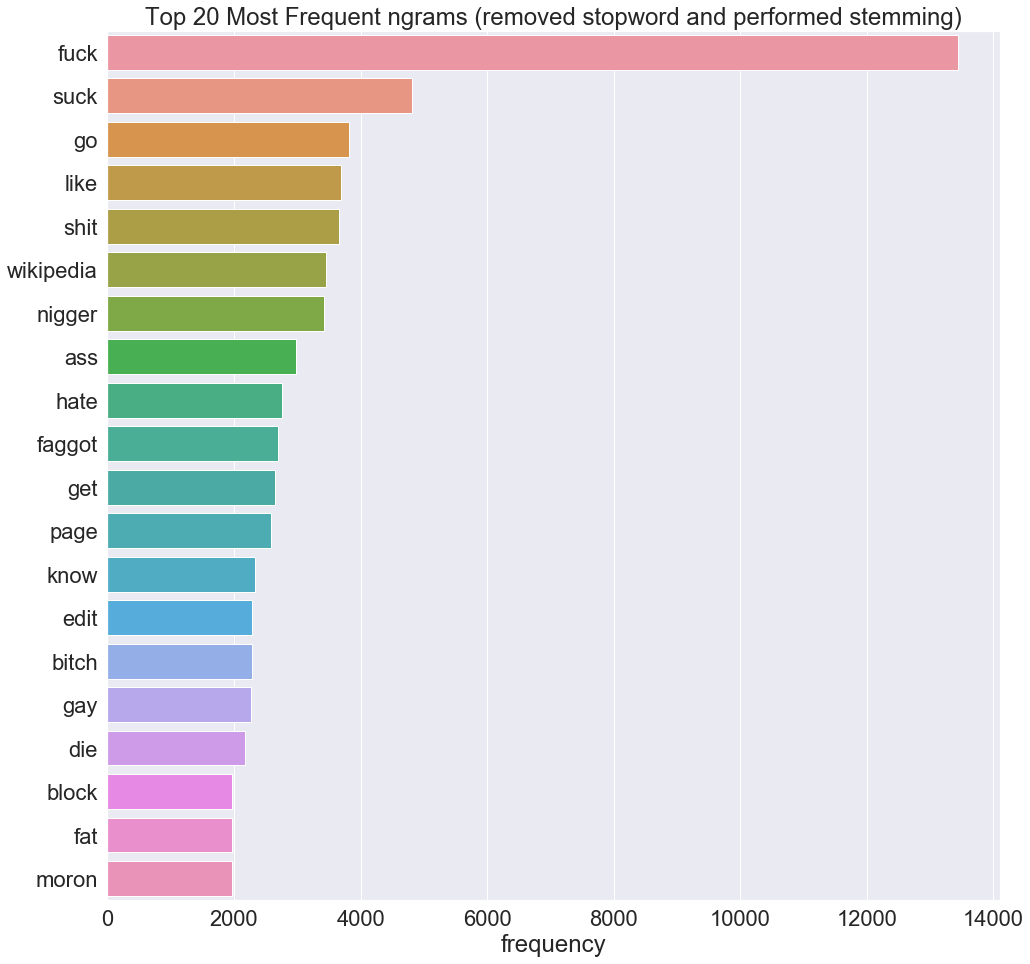

In [37]:
popular_ngrams(data_dict['toxic'],1,20)

### Break Down of toxic catogory and overlaps

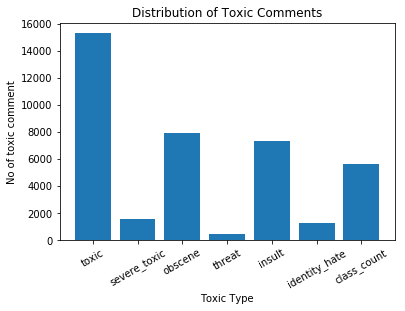

In [197]:
# Break Down of toxic catogory and overlaps
data_toxic = {}

for i in data.columns[2:]:
    data_toxic[i] = data_dict['toxic'][data_dict['toxic'][i] == 1]
    
plot_dist(data_toxic)

In [196]:
tags = ['JJ','JJR','JJS','NN','NNS','NNP','NNPS','VB','VBD','VBG','VBN','VBP','VBZ']
#tags = ['NN','NNS','NNP','NNPS','VB','VBD','VBG','VBN','VBP','VBZ']

preprocess_text1 =  prepare_corpus_part1(data_dict['toxic'],20,10)
preprocess_text2 =  prepare_corpus_part2(preprocess_text1,tags)
dictionary, corpus, text_data =  prepare_corpus_part3(preprocess_text2,5,0.6)

Currently processing sentence 1000/15294
Currently processing sentence 2000/15294
Currently processing sentence 3000/15294
Currently processing sentence 4000/15294
Currently processing sentence 5000/15294
Currently processing sentence 6000/15294
Currently processing sentence 7000/15294
Currently processing sentence 8000/15294
Currently processing sentence 9000/15294
Currently processing sentence 10000/15294
Currently processing sentence 11000/15294
Currently processing sentence 12000/15294
Currently processing sentence 13000/15294
Currently processing sentence 14000/15294
Currently processing sentence 15000/15294


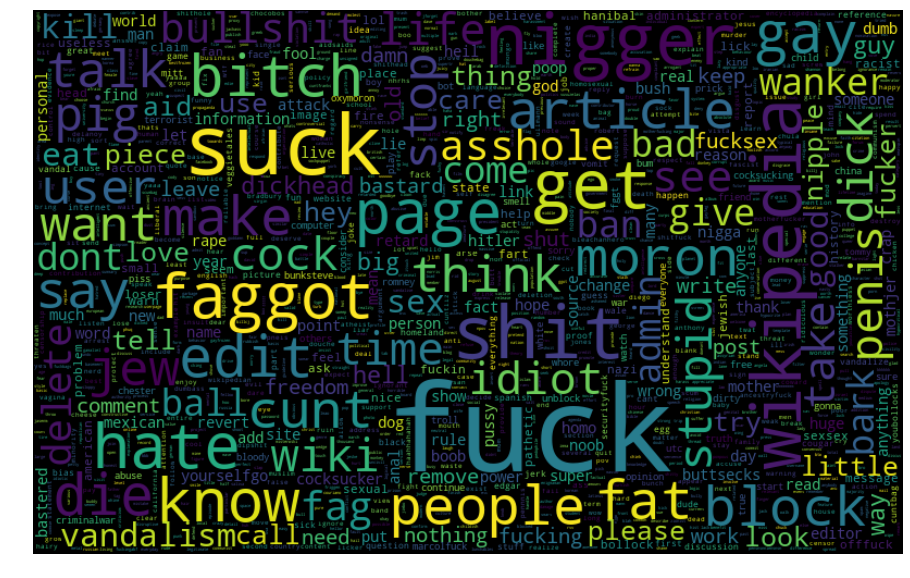

In [198]:
# new_stopwords = stop_words + ["one","two","three","four","five","six","seven","eight","nine"]
list_sent = [" ".join(text) for text in text_data]
all_words = ' '.join([text for text in list_sent])
#all_words = ' '.join([text for text in data_dict['toxic']["comment_text"]])
wordcloud = WordCloud(max_words=2000,width=800, height=500, random_state=21, max_font_size=110,stopwords=stop_words,collocations=False).generate(all_words)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Start modeling topic 2 at Mon Nov 11 16:14:53 2019
Model of 2 topics has the coherence 0.4898762808200378
Start modeling topic 3 at Mon Nov 11 16:15:29 2019
Model of 3 topics has the coherence 0.515063814347631
Start modeling topic 4 at Mon Nov 11 16:16:10 2019
Model of 4 topics has the coherence 0.496719824056387
Start modeling topic 5 at Mon Nov 11 16:17:03 2019
Model of 5 topics has the coherence 0.48350609607697814
Start modeling topic 6 at Mon Nov 11 16:17:59 2019
Model of 6 topics has the coherence 0.5400098469088644
Start modeling topic 7 at Mon Nov 11 16:18:41 2019
Model of 7 topics has the coherence 0.5134194860764641
Start modeling topic 8 at Mon Nov 11 16:19:29 2019
Model of 8 topics has the coherence 0.4960997656223474
Start modeling topic 9 at Mon Nov 11 16:20:22 2019
Model of 9 topics has the coherence 0.5274846056768047
Start modeling topic 10 at Mon Nov 11 16:21:12 2019
Model of 10 topics has the coherence 0.510025974222244


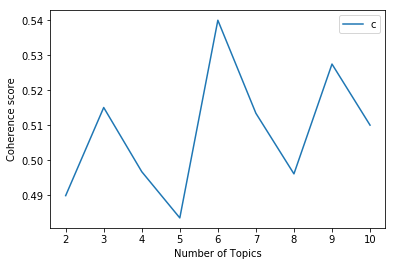

In [199]:
model_list_toxic, coherence_values_toxic = compute_coherence_values(dictionary, corpus, text_data, 11, 2, 1,100,10)
df_coherence_toxic = pd.DataFrame(list(zip(list(range(2,11,1)),coherence_values_toxic)),columns=('num_topics','coherence_value'))
best_index_toxic = coherence_values_toxic.index(max(coherence_values_toxic))
best_model_toxic = model_list_toxic[best_index_toxic]

In [202]:
dftoxic = convert_to_table(format_unique_topics(model_list_toxic[4].print_topics(num_topics=100, num_words=20)))
dftoxic

Number of unique topics: 6


Topic 1      Topic 2    Topic 3     Topic 4    Topic 5    Topic 6
word 1      fuck       faggot        get         aid       huge       suck
word 2      hate         shit       page         die       care        fat
word 3    nigger          gay       know         fag       dont        jew
word 4     bitch        moron  wikipedia    bullshit      penis       cock
word 5      cunt          bad     people         hey    fucking       dick
word 6       dog         wiki       make      fucker     retard       love
word 7       eat        piece    article    dickhead      super     nipple
word 8    stupid         bush      block      wanker       take  wikipedia
word 9   bastard    vandalism       talk         guy       damn        old
word 10     shut         ball        say  cocksucker        ban       rice
word 11    pussy       admins      think        kill       anal    asshole
word 12   mother  cocksucking       stop     mothjer       fart        sex
word 13  hanibal        jones       edit     chicken  terrorist       boob
word 14  faggots       hitler       time       hairy   computer     vagina
word 15     want        admin       want        fool       arse       lick
word 16    nigga         poop      idiot       image       come       user
word 17  delanoy       cheese     delete      fuckin      block       homo
word 18      egg         hell        see        tell     sexual      dirty
word 19    vomit         rule       life         fan      small      whore
word 20    cline       george     stupid       white        say        big

## Severe_toxic 

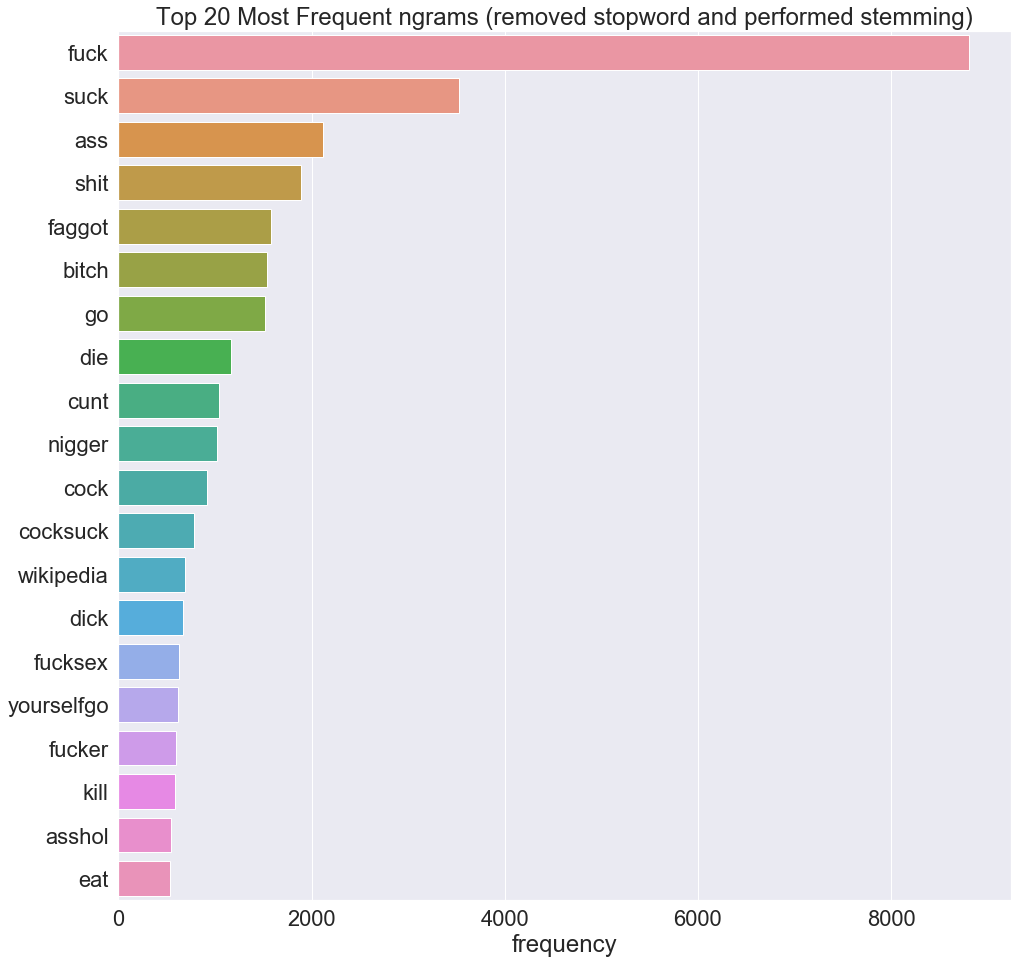

In [38]:
popular_ngrams(data_dict['severe_toxic'],1,20)

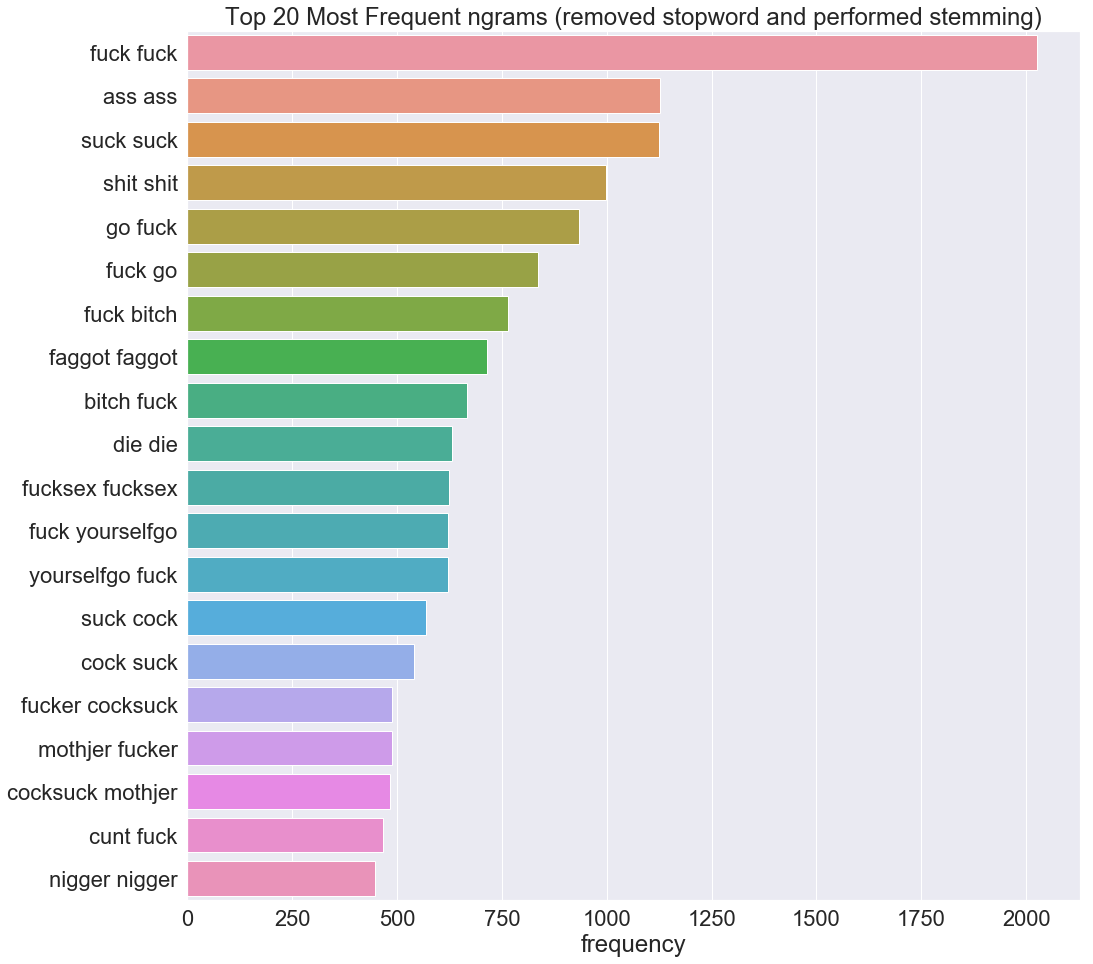

In [39]:
popular_ngrams(data_dict['severe_toxic'],2,20)

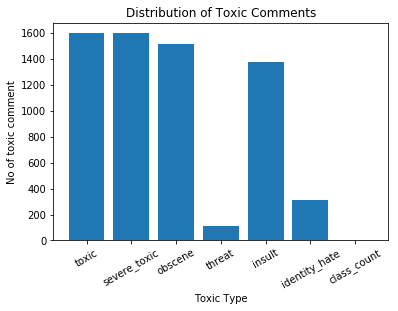

In [204]:
# Break Down
data_stoxic = {}

for i in data.columns[2:]:
    data_stoxic[i] = data_dict['severe_toxic'][data_dict['severe_toxic'][i] == 1]
    
plot_dist(data_stoxic)

In [205]:
tags = ['JJ','JJR','JJS','NN','NNS','NNP','NNPS','VB','VBD','VBG','VBN','VBP','VBZ']
#tags = ['NN','NNS','NNP','NNPS','VB','VBD','VBG','VBN','VBP','VBZ']

preprocess_text1 =  prepare_corpus_part1(data_dict['severe_toxic'],20,10)
preprocess_text2 =  prepare_corpus_part2(preprocess_text1,tags)
dictionary, corpus, text_data =  prepare_corpus_part3(preprocess_text2,5,0.6)

Currently processing sentence 1000/1595


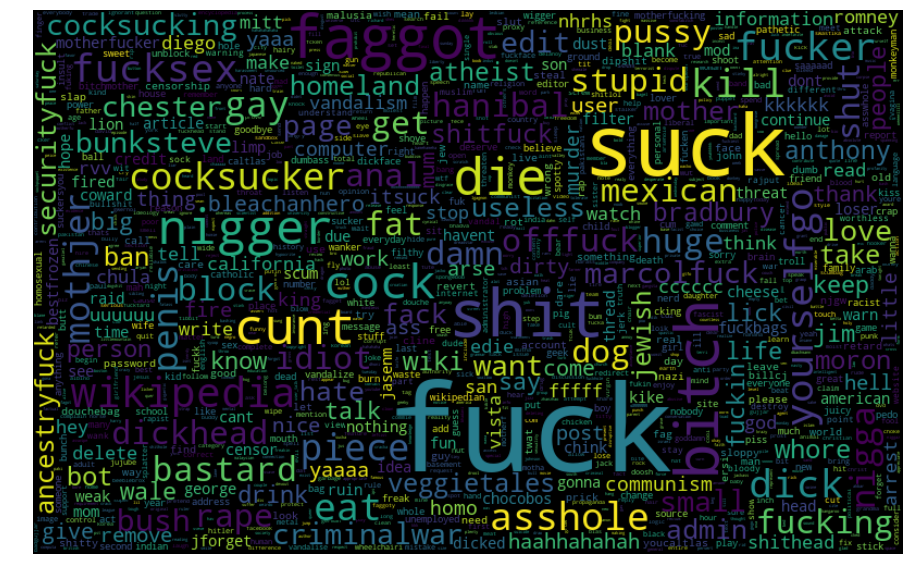

In [208]:
# new_stopwords = stop_words + ["one","two","three","four","five","six","seven","eight","nine"]
list_sent = [" ".join(text) for text in text_data]
all_words = ' '.join([text for text in list_sent])
#all_words = ' '.join([text for text in data_dict['toxic']["comment_text"]])
wordcloud = WordCloud(max_words=2000,width=800, height=500, random_state=21, max_font_size=110,stopwords=stop_words,collocations=False).generate(all_words)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Start modeling topic 2 at Mon Nov 11 16:25:23 2019
Model of 2 topics has the coherence 0.46438338721132677
Start modeling topic 3 at Mon Nov 11 16:25:36 2019
Model of 3 topics has the coherence 0.4326301451378849
Start modeling topic 4 at Mon Nov 11 16:25:51 2019
Model of 4 topics has the coherence 0.3935096286945574
Start modeling topic 5 at Mon Nov 11 16:26:05 2019
Model of 5 topics has the coherence 0.3743019563652925
Start modeling topic 6 at Mon Nov 11 16:26:20 2019
Model of 6 topics has the coherence 0.3694388521692742
Start modeling topic 7 at Mon Nov 11 16:26:35 2019
Model of 7 topics has the coherence 0.4117776440151967
Start modeling topic 8 at Mon Nov 11 16:26:50 2019
Model of 8 topics has the coherence 0.40103012082563727
Start modeling topic 9 at Mon Nov 11 16:27:05 2019
Model of 9 topics has the coherence 0.4068664989788658
Start modeling topic 10 at Mon Nov 11 16:27:20 2019
Model of 10 topics has the coherence 0.39716951343035034


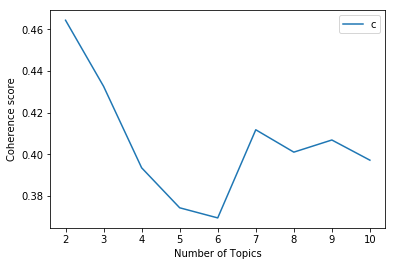

In [209]:
model_list_stoxic, coherence_values_stoxic = compute_coherence_values(dictionary, corpus, text_data, 11, 2, 1,100,10)
df_coherence_stoxic = pd.DataFrame(list(zip(list(range(2,11,1)),coherence_values_stoxic)),columns=('num_topics','coherence_value'))
best_index_stoxic = coherence_values_stoxic.index(max(coherence_values_stoxic))
best_model_stoxic = model_list_stoxic[best_index_stoxic]

In [210]:
dfstoxic = convert_to_table(format_unique_topics(model_list_stoxic[0].print_topics(num_topics=100, num_words=20)))
dfstoxic

Number of unique topics: 2


Topic 1  Topic 2
word 1         fuck     shit
word 2         suck   faggot
word 3        bitch     cunt
word 4          die     fuck
word 5         cock    piece
word 6    wikipedia    penis
word 7       nigger      eat
word 8       fucker  bastard
word 9         kill     huge
word 10     asshole     shut
word 11  cocksucker     damn
word 12     mothjer     rape
word 13        dick      fat
word 14         gay   stupid
word 15         dog     anal
word 16     mexican  fucking
word 17    dickhead   nigger
word 18       idiot    pussy
word 19        love      get
word 20        bush     want

## Obscene

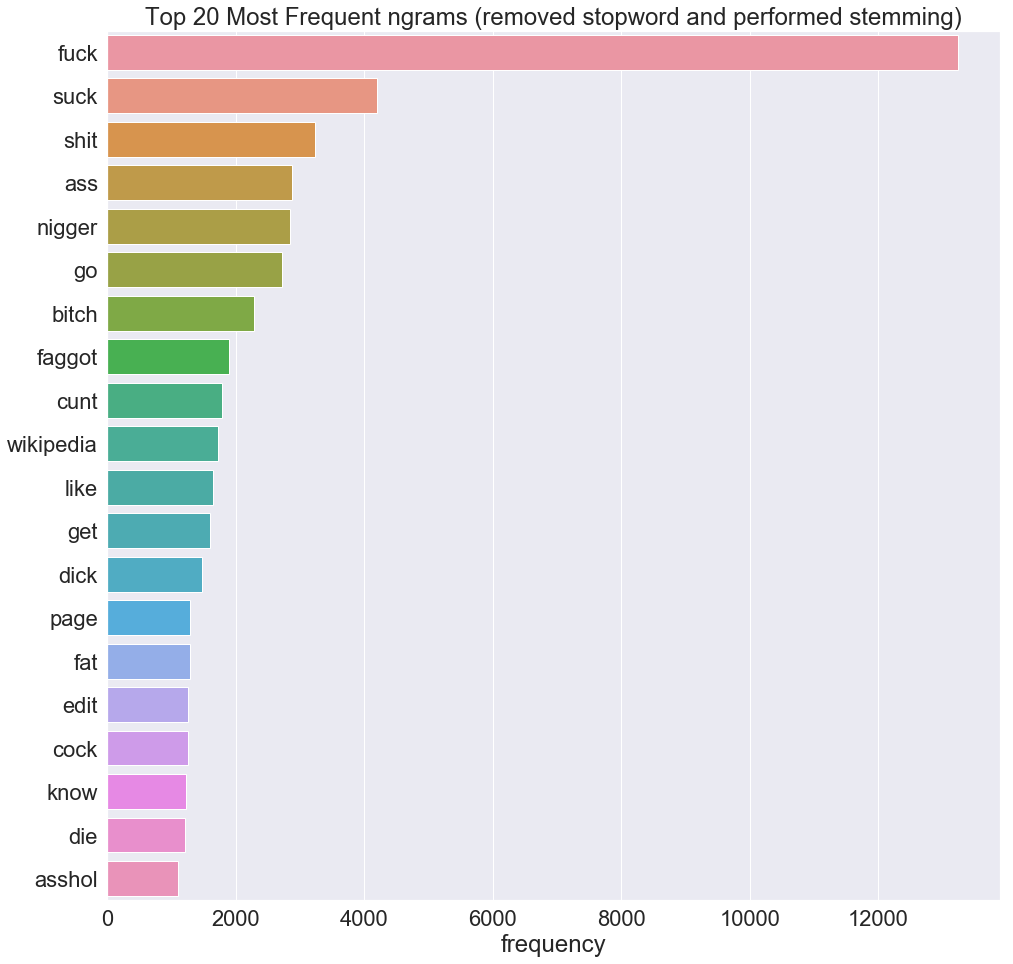

In [40]:
popular_ngrams(data_dict['obscene'],1,20)

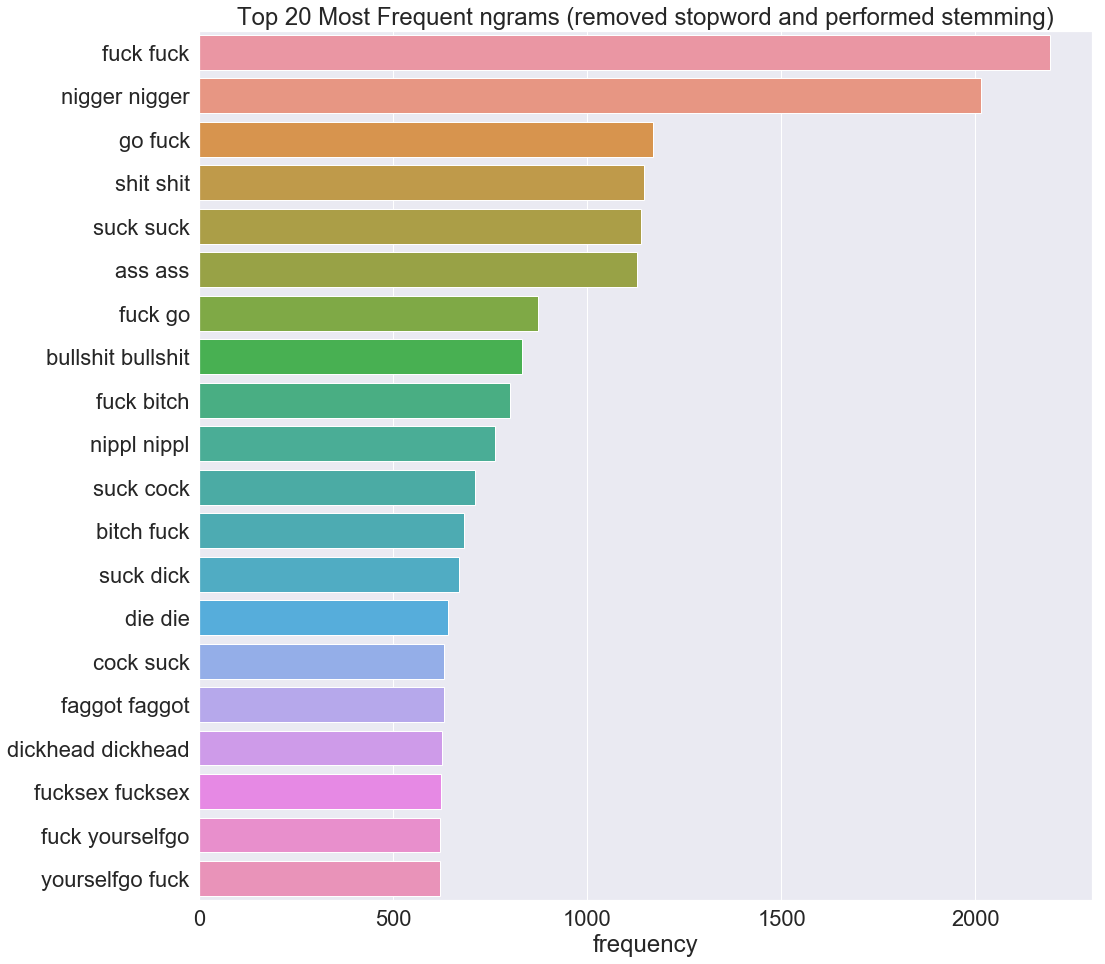

In [41]:
popular_ngrams(data_dict['obscene'],2,20)

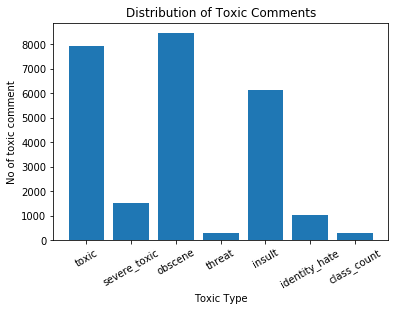

In [212]:
# Break Down
data_obscene = {}

for i in data.columns[2:]:
    data_obscene[i] = data_dict['obscene'][data_dict['obscene'][i] == 1]
    
plot_dist(data_obscene)

In [59]:
tags = ['JJ','JJR','JJS','NN','NNS','NNP','NNPS','VB','VBD','VBG','VBN','VBP','VBZ']
#tags = ['NN','NNS','NNP','NNPS','VB','VBD','VBG','VBN','VBP','VBZ']

preprocess_text1 =  prepare_corpus_part1(data_dict['obscene'],20,10)
preprocess_text2 =  prepare_corpus_part2(preprocess_text1,tags)
dictionary, corpus, text_data =  prepare_corpus_part3(preprocess_text2,5,0.5)

Currently processing sentence 1000/8449
Currently processing sentence 2000/8449
Currently processing sentence 3000/8449
Currently processing sentence 4000/8449
Currently processing sentence 5000/8449
Currently processing sentence 6000/8449
Currently processing sentence 7000/8449
Currently processing sentence 8000/8449


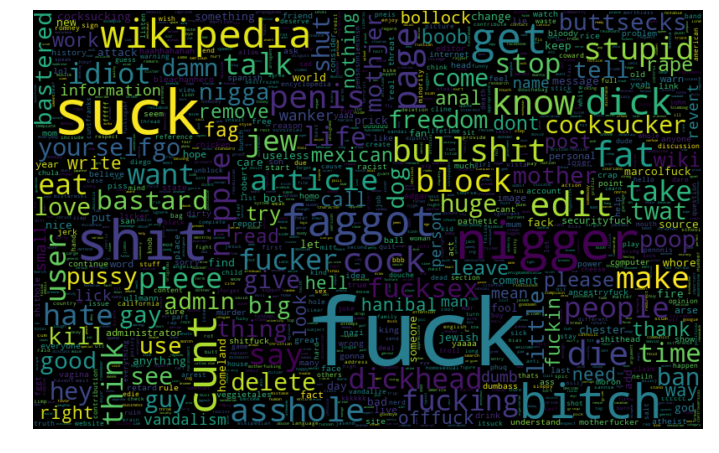

In [214]:
new_stopwords = stop_words + ["one","two","three","four","five","six","seven","eight","nine"]
list_sent = [" ".join(text) for text in text_data]
all_words = ' '.join([text for text in list_sent])
#all_words = ' '.join([text for text in data_dict['toxic']["comment_text"]])
wordcloud = WordCloud(max_words=2000,width=800, height=500, random_state=21, max_font_size=110,stopwords=stop_words,collocations=False).generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Start modeling topic 2 at Tue Nov 19 00:23:18 2019
Model of 2 topics has the coherence 0.5570026802366219
Start modeling topic 3 at Tue Nov 19 00:23:48 2019
Model of 3 topics has the coherence 0.4436377956466318
Start modeling topic 4 at Tue Nov 19 00:24:23 2019
Model of 4 topics has the coherence 0.516919858672104
Start modeling topic 5 at Tue Nov 19 00:24:56 2019
Model of 5 topics has the coherence 0.45384195581394404
Start modeling topic 6 at Tue Nov 19 00:25:33 2019
Model of 6 topics has the coherence 0.5001477498037067
Start modeling topic 7 at Tue Nov 19 00:26:08 2019
Model of 7 topics has the coherence 0.5038134628949046
Start modeling topic 8 at Tue Nov 19 00:26:40 2019
Model of 8 topics has the coherence 0.5155298839822614
Start modeling topic 9 at Tue Nov 19 00:27:12 2019
Model of 9 topics has the coherence 0.5349226845736607
Start modeling topic 10 at Tue Nov 19 00:27:46 2019
Model of 10 topics has the coherence 0.49865455536087067


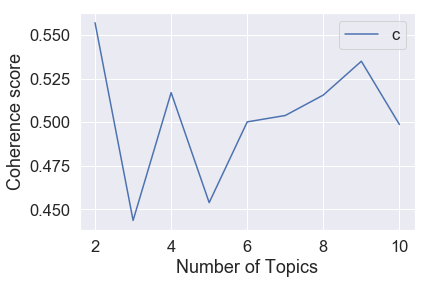

In [62]:
model_list_obscene, coherence_values_obscene = compute_coherence_values(dictionary, corpus, text_data, 11, 2, 1,100,10)
df_coherence_obscene = pd.DataFrame(list(zip(list(range(2,11,1)),coherence_values_obscene)),columns=('num_topics','coherence_value'))
best_index_obscene = coherence_values_obscene.index(max(coherence_values_obscene))
best_model_obscene = model_list_obscene[best_index_obscene]

In [63]:
dfobscene = convert_to_table(format_unique_topics(model_list_obscene[0].print_topics(num_topics=100, num_words=20)))
dfobscene

Number of unique topics: 2


Topic 1    Topic 2
word 1         fuck     faggot
word 2         suck     nigger
word 3        bitch       huge
word 4         shit     stupid
word 5         love       fuck
word 6          hey        get
word 7          guy       page
word 8         dick       know
word 9         cock        fag
word 10      fucker  wikipedia
word 11        cunt      block
word 12     chicken       shit
word 13     bastard       make
word 14  cocksucker        die
word 15     mothjer     people
word 16       penis        say
word 17      vagina       edit
word 18      nipple    article
word 19    bullshit       talk
word 20     hanibal      think

## Threat

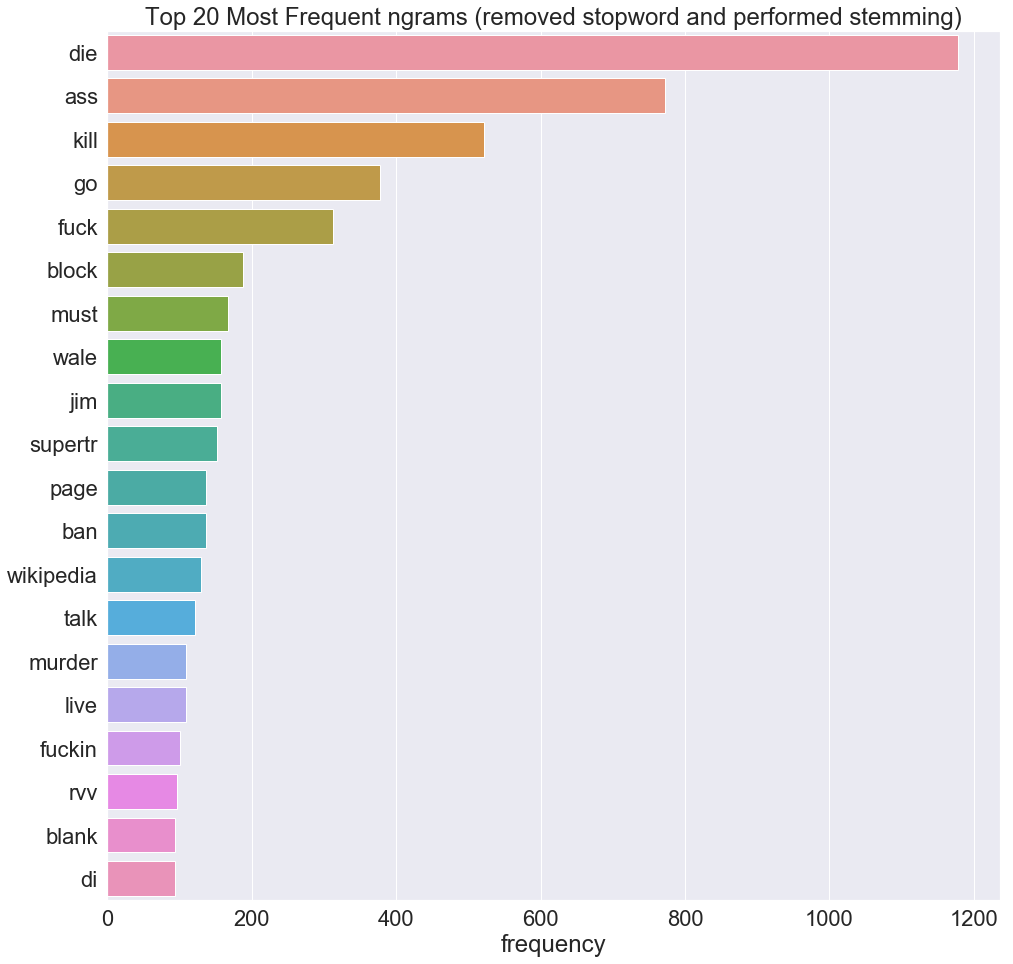

In [44]:
popular_ngrams(data_dict['threat'],1,20)

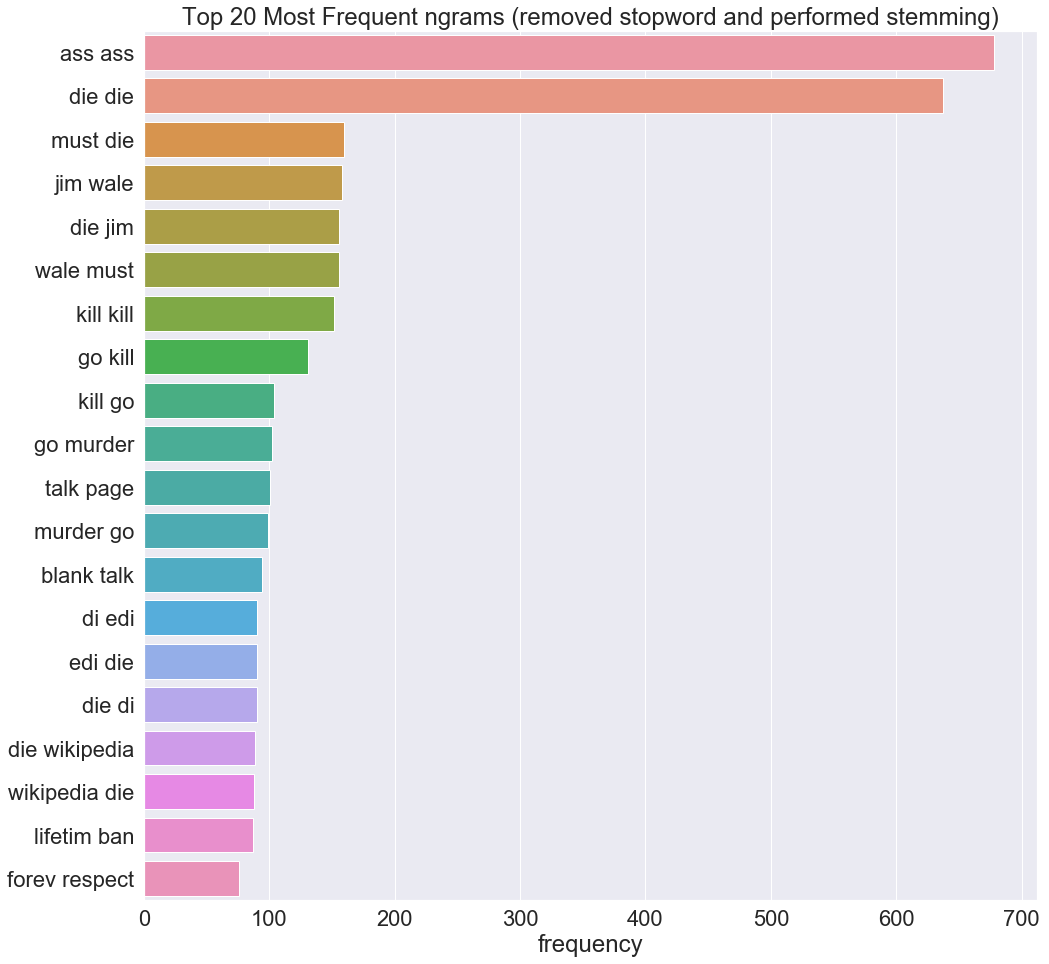

In [45]:
popular_ngrams(data_dict['threat'],2,20)

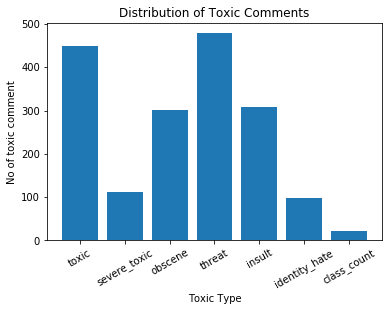

In [218]:
# Break Down
data_threat = {}

for i in data.columns[2:]:
    data_threat[i] = data_dict['threat'][data_dict['threat'][i] == 1]
    
plot_dist(data_threat)

In [219]:
tags = ['JJ','JJR','JJS','NN','NNS','NNP','NNPS','VB','VBD','VBG','VBN','VBP','VBZ']
#tags = ['NN','NNS','NNP','NNPS','VB','VBD','VBG','VBN','VBP','VBZ']

preprocess_text1 =  prepare_corpus_part1(data_dict['threat'],20,10)
preprocess_text2 =  prepare_corpus_part2(preprocess_text1,tags)
dictionary, corpus, text_data =  prepare_corpus_part3(preprocess_text2,5,0.6)

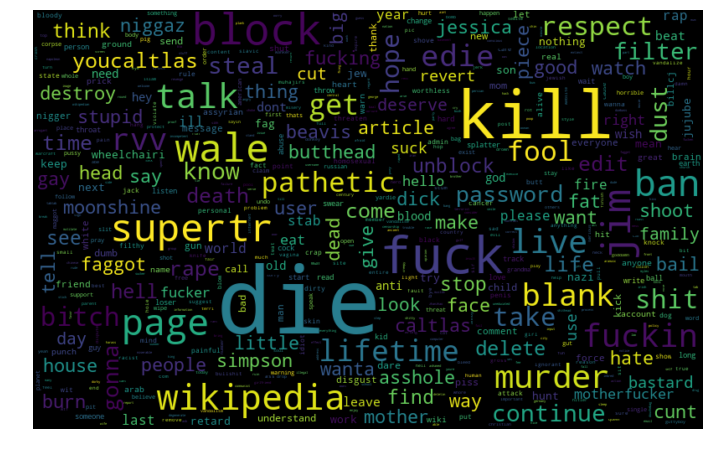

In [220]:
new_stopwords = stop_words + ["one","two","three","four","five","six","seven","eight","nine"]
list_sent = [" ".join(text) for text in text_data]
all_words = ' '.join([text for text in list_sent])
#all_words = ' '.join([text for text in data_dict['toxic']["comment_text"]])
wordcloud = WordCloud(max_words=2000,width=800, height=500, random_state=21, max_font_size=110,stopwords=stop_words,collocations=False).generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Start modeling topic 2 at Mon Nov 11 16:48:21 2019
Model of 2 topics has the coherence 0.4378632215654513
Start modeling topic 3 at Mon Nov 11 16:48:28 2019
Model of 3 topics has the coherence 0.4997827778544465
Start modeling topic 4 at Mon Nov 11 16:48:34 2019
Model of 4 topics has the coherence 0.5183704965921274
Start modeling topic 5 at Mon Nov 11 16:48:41 2019
Model of 5 topics has the coherence 0.5142685204970181
Start modeling topic 6 at Mon Nov 11 16:48:48 2019
Model of 6 topics has the coherence 0.49299905015099227
Start modeling topic 7 at Mon Nov 11 16:48:56 2019
Model of 7 topics has the coherence 0.44654618202879715
Start modeling topic 8 at Mon Nov 11 16:49:02 2019
Model of 8 topics has the coherence 0.44734728302322657
Start modeling topic 9 at Mon Nov 11 16:49:09 2019
Model of 9 topics has the coherence 0.43201277654088144
Start modeling topic 10 at Mon Nov 11 16:49:17 2019
Model of 10 topics has the coherence 0.42325875108985694


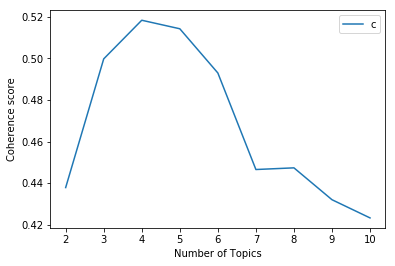

In [221]:
model_list_threat, coherence_values_threat = compute_coherence_values(dictionary, corpus, text_data, 11, 2, 1,100,10)
df_coherence_threat = pd.DataFrame(list(zip(list(range(2,11,1)),coherence_values_threat)),columns=('num_topics','coherence_value'))
best_index_threat = coherence_values_threat.index(max(coherence_values_threat))
best_model_threat = model_list_threat[best_index_threat]

In [222]:
dfthreat = convert_to_table(format_unique_topics(model_list_threat[2].print_topics(num_topics=100, num_words=20)))
dfthreat

Number of unique topics: 4


Topic 1   Topic 2    Topic 3 Topic 4
word 1     fuck      kill        die    fuck
word 2     time     block  wikipedia    shit
word 3      get       ban       live    kill
word 4     stop      talk   pathetic     get
word 5     know      page       fool   bitch
word 6   people    murder       fuck    hope
word 7     want    fuckin      bitch    hell
word 8      see      take       rape    come
word 9     edit     steal        fat  delete
word 10  stupid  continue       head   death
word 11    look      fuck        jew    know
word 12    cunt     gonna      shoot   piece
word 13    life      user        mom    dead
word 14    head   destroy     ground    life
word 15     fat      skin     stupid    rape
word 16    make     shove       hope     say
word 17    hope       cut      brain    burn
word 18  revert       ass   splatter   think
word 19   edits       use        son   house
word 20    give      pull       nazi    page

## Insult

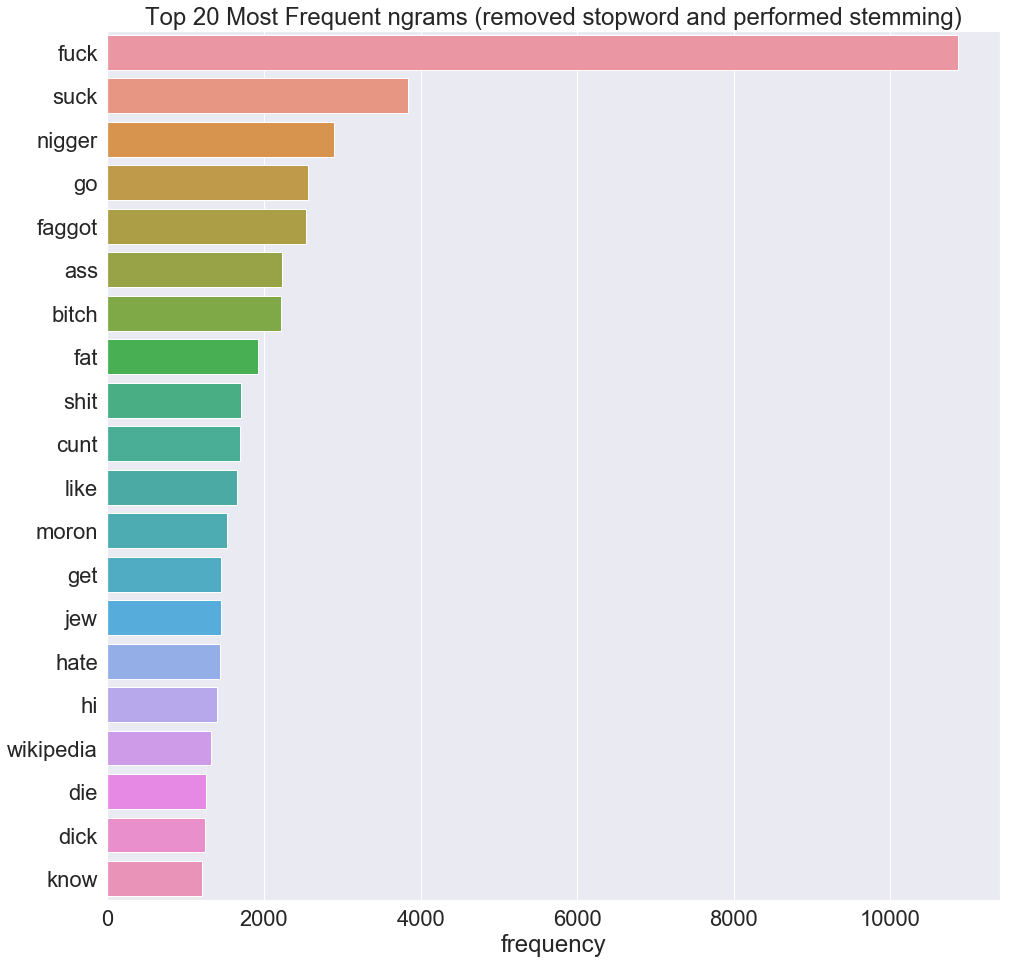

In [46]:
popular_ngrams(data_dict['insult'],1,20)

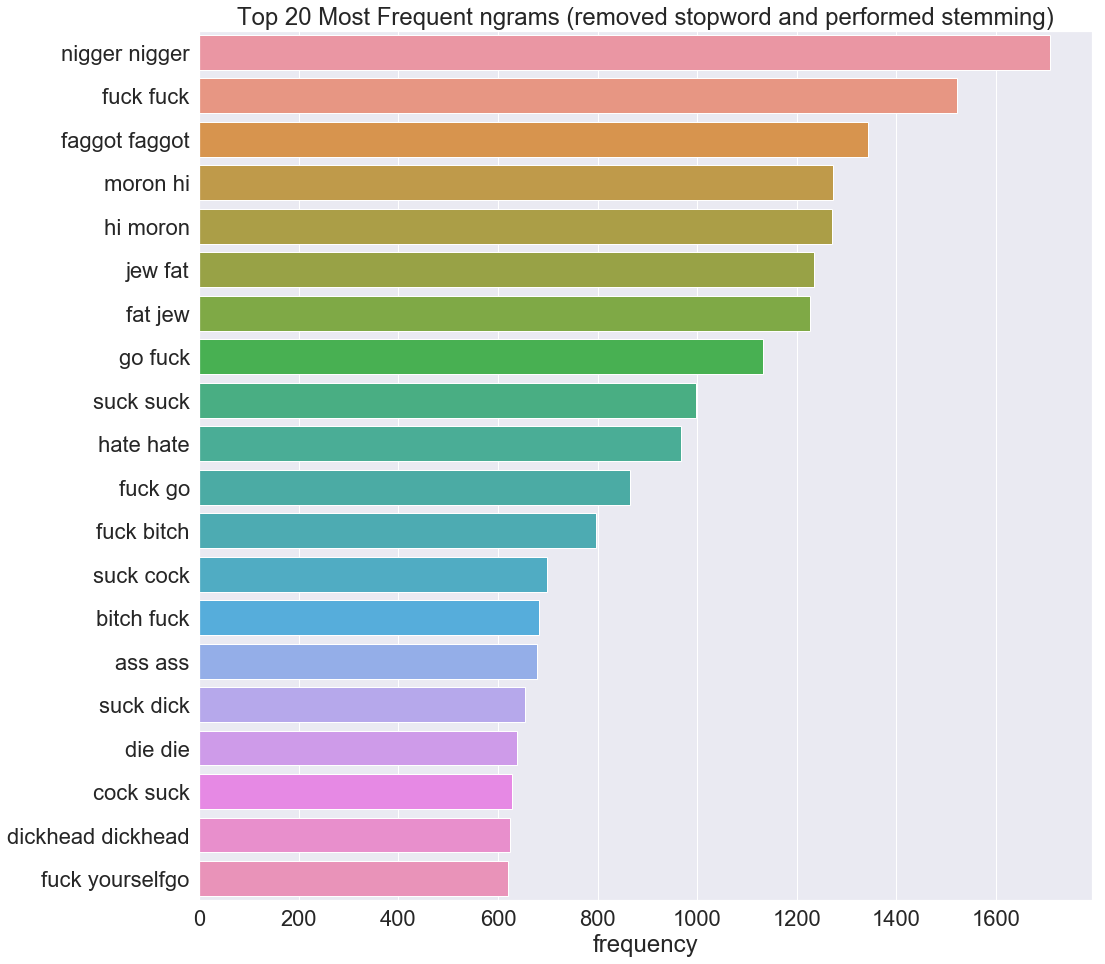

In [47]:
popular_ngrams(data_dict['insult'],2,20)

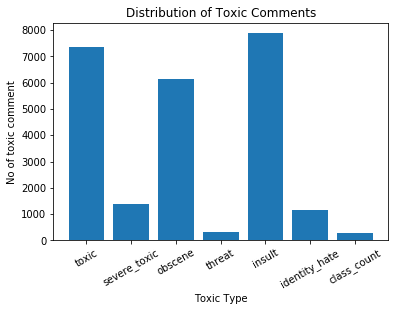

In [224]:
# Break Down
data_insult = {}

for i in data.columns[2:]:
    data_insult[i] = data_dict['insult'][data_dict['insult'][i] == 1]
    
plot_dist(data_insult)

In [64]:
tags = ['JJ','JJR','JJS','NN','NNS','NNP','NNPS','VB','VBD','VBG','VBN','VBP','VBZ']
#tags = ['NN','NNS','NNP','NNPS','VB','VBD','VBG','VBN','VBP','VBZ']

preprocess_text1 =  prepare_corpus_part1(data_dict['insult'],20,10)
preprocess_text2 =  prepare_corpus_part2(preprocess_text1,tags)
dictionary, corpus, text_data =  prepare_corpus_part3(preprocess_text2,5,0.6)

Currently processing sentence 1000/7877
Currently processing sentence 2000/7877
Currently processing sentence 3000/7877
Currently processing sentence 4000/7877
Currently processing sentence 5000/7877
Currently processing sentence 6000/7877
Currently processing sentence 7000/7877


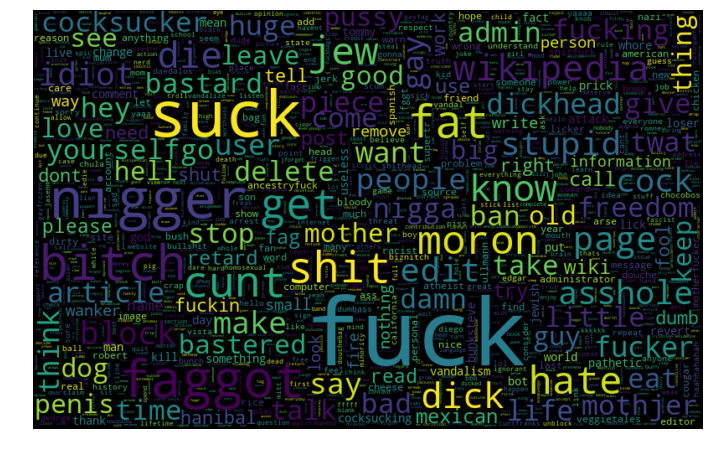

In [226]:
new_stopwords = stop_words + ["one","two","three","four","five","six","seven","eight","nine"]
list_sent = [" ".join(text) for text in text_data]
all_words = ' '.join([text for text in list_sent])
#all_words = ' '.join([text for text in data_dict['toxic']["comment_text"]])
wordcloud = WordCloud(max_words=2000,width=800, height=500, random_state=21, max_font_size=110,stopwords=stop_words,collocations=False).generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Start modeling topic 2 at Tue Nov 19 00:49:03 2019
Model of 2 topics has the coherence 0.47156373266810614
Start modeling topic 4 at Tue Nov 19 00:49:40 2019
Model of 4 topics has the coherence 0.4791899784772682
Start modeling topic 6 at Tue Nov 19 00:50:22 2019
Model of 6 topics has the coherence 0.48110055254557144
Start modeling topic 8 at Tue Nov 19 00:51:06 2019
Model of 8 topics has the coherence 0.4953155848939383
Start modeling topic 10 at Tue Nov 19 00:51:52 2019
Model of 10 topics has the coherence 0.4959616296233288
Start modeling topic 12 at Tue Nov 19 00:52:40 2019
Model of 12 topics has the coherence 0.5048716761707795
Start modeling topic 14 at Tue Nov 19 00:53:25 2019
Model of 14 topics has the coherence 0.5096969337019767
Start modeling topic 16 at Tue Nov 19 00:54:16 2019
Model of 16 topics has the coherence 0.5083452460210872
Start modeling topic 18 at Tue Nov 19 00:54:55 2019
Model of 18 topics has the coherence 0.5581396159382227
Start modeling topic 20 at Tue Nov

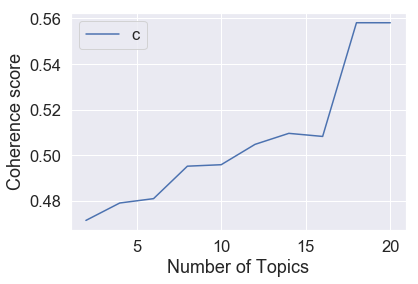

In [65]:
model_list_insult, coherence_values_insult = compute_coherence_values(dictionary, corpus, text_data, 21, 2, 2,100,10)
df_coherence_insult = pd.DataFrame(list(zip(list(range(2,11,1)),coherence_values_insult)),columns=('num_topics','coherence_value'))
best_index_insult = coherence_values_insult.index(max(coherence_values_insult))
best_model_insult = model_list_insult[best_index_insult]

In [67]:
dfinsult = convert_to_table(format_unique_topics(best_model_insult.print_topics(num_topics=10, num_words=20)))
dfinsult

Number of unique topics: 10


Topic 1   Topic 2    Topic 3  Topic 4        Topic 5   Topic 6  \
word 1        nigger       fat    fucking     cock           suck      know   
word 2         moron       jew      penis     huge           dick       die   
word 3       chicken       old       fire     twat        mexican      fool   
word 4        middle    repeat      small   retard           john  pathetic   
word 5        ethnic      dumb      mouth    whore           slap      time   
word 6       cracker      scum      house    dirty         thomas    people   
word 7        bridge    coward        god      eat          voice      live   
word 8      talkpage  american        use      lol           july     image   
word 9        damage       mod  douchebag     jerk          fukin     tommy   
word 10  association      limp    dipshit     blah          plain      year   
word 11       slavic     asian       damn   sucker  insignificant     world   
word 12     username       sue    opinion   indian        reverts   respect   
word 13        blind    commie     police     meet           cena     claim   
word 14         iraq    muslim      large      fuk        monitor      hope   
word 15       detail      sikh       turd     tool            dam       way   
word 16  participate      rant      treat   online         direct   nothing   
word 17         wash      arab        hot     inch           pope      mean   
word 18       oppose      rich     expert      bro        bigoted      fact   
word 19       united  redirect        boy  fuckwit          alert      find   
word 20        royal     thick  miserable     pain            hog   country   

             Topic 7    Topic 8      Topic 9   Topic 10  
word 1          fuck  wikipedia          get    asshole  
word 2          shit        guy        block      idiot  
word 3           eat       love       little       page  
word 4          shut     please         life     delete  
word 5        admins       stop         come     people  
word 6          cunt      think          say       make  
word 7   cocksucking        see       fuckin  wikipedia  
word 8        mother     change          big    article  
word 9       atheist       dont         make      leave  
word 10        semen     stupid          man     person  
word 11          ban        say         post      think  
word 12         cant       want  information       stop  
word 13         warn       give     computer  vandalism  
word 14         sign       care         shit       user  
word 15        write       edit          day        get  
word 16          mum       call         real       edit  
word 17         face     people     shithead      right  
word 18          pic   anything          job       good  
word 19       fucken       like         hope       talk  
word 20      gwernol   everyone          mom        put

## Identity Hate

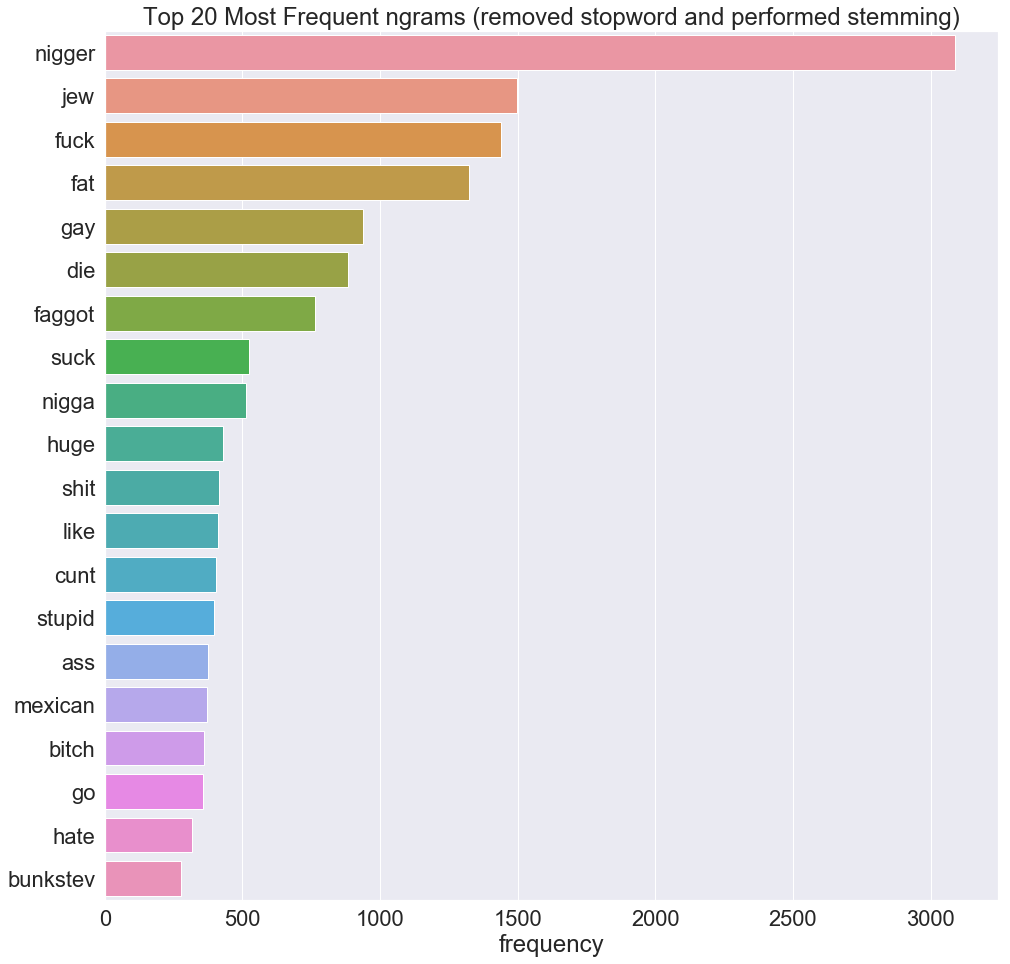

In [48]:
popular_ngrams(data_dict['identity_hate'],1,20)

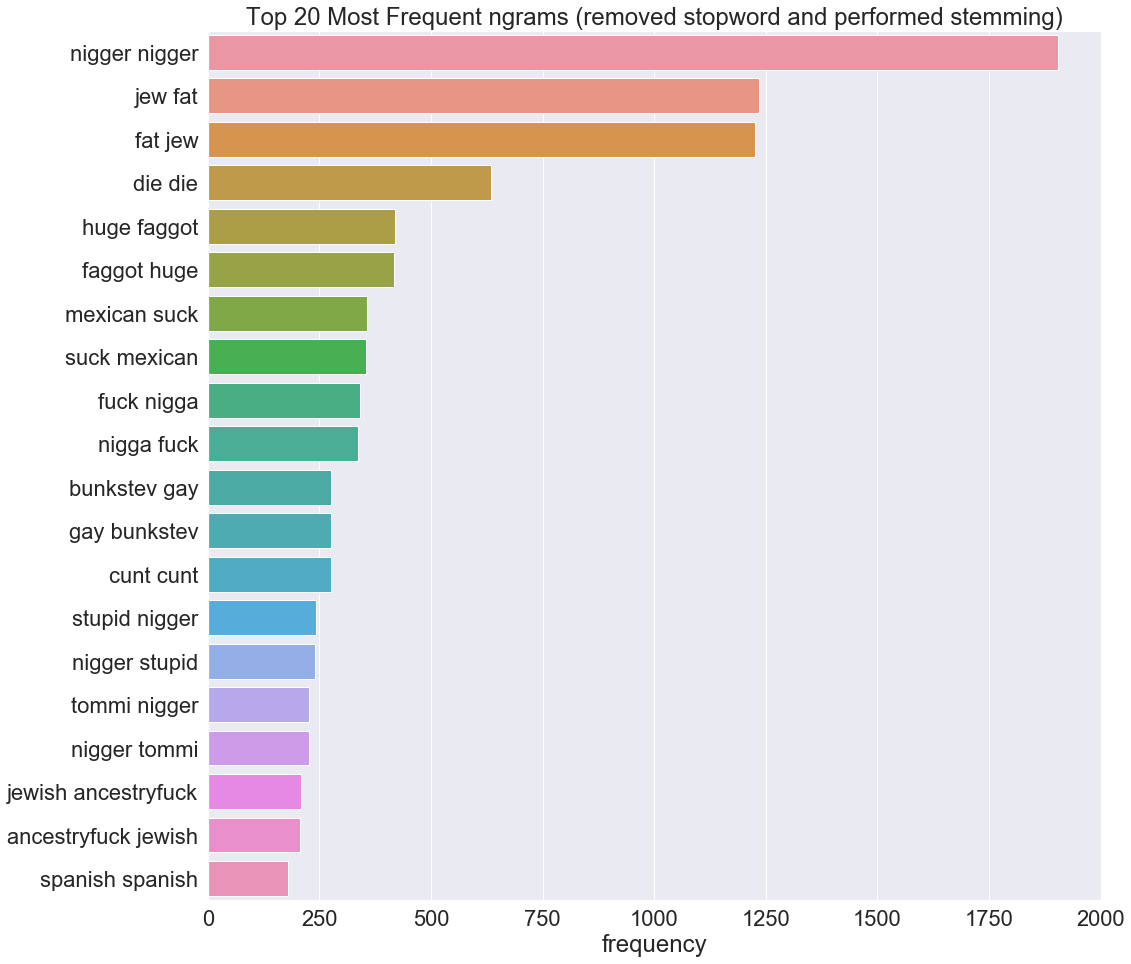

In [49]:
popular_ngrams(data_dict['identity_hate'],2,20)

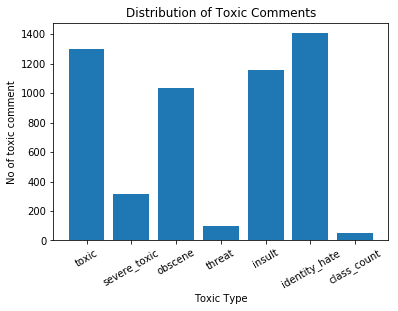

In [230]:
# Break Down
data_hate = {}

for i in data.columns[2:]:
    data_hate[i] = data_dict['identity_hate'][data_dict['identity_hate'][i] == 1]
    
plot_dist(data_hate)

In [231]:
tags = ['JJ','JJR','JJS','NN','NNS','NNP','NNPS','VB','VBD','VBG','VBN','VBP','VBZ']
#tags = ['NN','NNS','NNP','NNPS','VB','VBD','VBG','VBN','VBP','VBZ']

preprocess_text1 =  prepare_corpus_part1(data_dict['identity_hate'],20,10)
preprocess_text2 =  prepare_corpus_part2(preprocess_text1,tags)
dictionary, corpus, text_data =  prepare_corpus_part3(preprocess_text2,5,0.6)

Currently processing sentence 1000/1405


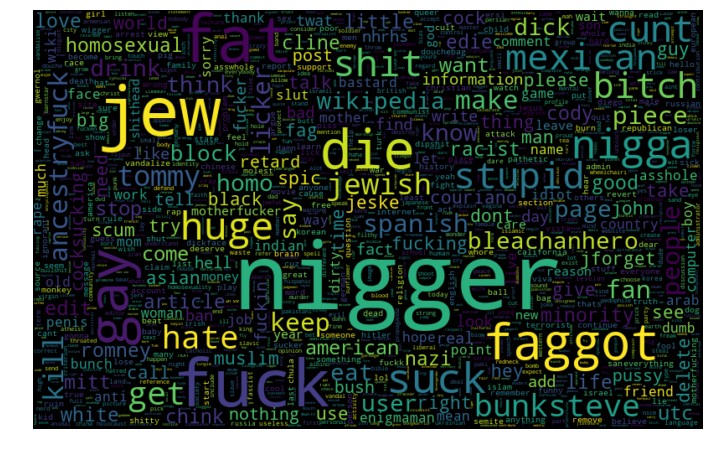

In [232]:
new_stopwords = stop_words + ["one","two","three","four","five","six","seven","eight","nine"]
list_sent = [" ".join(text) for text in text_data]
all_words = ' '.join([text for text in list_sent])
#all_words = ' '.join([text for text in data_dict['toxic']["comment_text"]])
wordcloud = WordCloud(max_words=2000,width=800, height=500, random_state=21, max_font_size=110,stopwords=stop_words,collocations=False).generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Start modeling topic 2 at Mon Nov 11 17:51:29 2019
Model of 2 topics has the coherence 0.5281629079725931
Start modeling topic 3 at Mon Nov 11 17:51:43 2019
Model of 3 topics has the coherence 0.5049292792478387
Start modeling topic 4 at Mon Nov 11 17:51:58 2019
Model of 4 topics has the coherence 0.45064612697503853
Start modeling topic 5 at Mon Nov 11 17:52:14 2019
Model of 5 topics has the coherence 0.4696836658969942
Start modeling topic 6 at Mon Nov 11 17:52:32 2019
Model of 6 topics has the coherence 0.44557829182403347
Start modeling topic 7 at Mon Nov 11 17:52:47 2019
Model of 7 topics has the coherence 0.46788921973181125
Start modeling topic 8 at Mon Nov 11 17:53:01 2019
Model of 8 topics has the coherence 0.48843990553151895
Start modeling topic 9 at Mon Nov 11 17:53:16 2019
Model of 9 topics has the coherence 0.4928623745762846
Start modeling topic 10 at Mon Nov 11 17:53:35 2019
Model of 10 topics has the coherence 0.4959465728329581


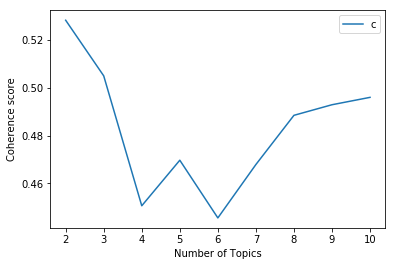

In [233]:
model_list_hate, coherence_values_hate = compute_coherence_values(dictionary, corpus, text_data, 11, 2, 1,100,10)
df_coherence_hate = pd.DataFrame(list(zip(list(range(2,11,1)),coherence_values_hate)),columns=('num_topics','coherence_value'))
best_index_hate = coherence_values_hate.index(max(coherence_values_hate))
best_model_hate = model_list_hate[best_index_hate]

In [234]:
dfhate = convert_to_table(format_unique_topics(model_list_hate[0].print_topics(num_topics=100, num_words=20)))
dfhate

Number of unique topics: 2


Topic 1 Topic 2
word 1      faggot  nigger
word 2        fuck     jew
word 3        suck     fat
word 4        huge     die
word 5     mexican    fuck
word 6         gay     gay
word 7         get    cunt
word 8      jewish  stupid
word 9        make    hate
word 10     people    shit
word 11       shit   bitch
word 12      bitch  licker
word 13       page    kill
word 14       know   drink
word 15       dick   nigga
word 16  wikipedia    keep
word 17      think     eat
word 18        say    homo
word 19       want  faggot
word 20       stop     utc